**<h1>Group Project</h1>**

**<h1>Crime Classification in San Francisco: Predicting Crime Categories Based on Time and Location</h1>**
---

> 

   **<h2>Group members</h2>**


*   Hranush Sahradyan
*   Hasmik Margaryan
*   Ishkhanuhi Hakobyan


>

**<h2>Purpose of the project</h2>**

This assignment focuses on building a machine learning model for crime classification in San Francisco. The dataset used for this project contains approximately 12 years of crime reports from various neighborhoods in the city. The goal is to predict the category of crime based on the given time and location information.

**<h2>Dataset Overview</h2>**

The dataset used in this project is sourced from Kaggle and provides comprehensive crime reports from 1934 to 1963. The dataset covers various neighborhoods in San Francisco, including Sunset, SOMA, Marina, and Excelsior. Each crime report entry includes information such as the date, time, and location of the crime, as well as the reported crime category. Here is the [kaggle page](https://www.kaggle.com/competitions/sf-crime/overview) of the assignment.


**<h2>Dataset Description</h2>**

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

**Data fields**
* **Dates** - timestamp of the crime incident
* **Category** - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
* **Descript** - detailed description of the crime incident (only in train.csv)
* **DayOfWeek** - the day of the week
* **PdDistrict** - name of the Police Department District
* **Resolution** - how the crime incident was resolved (only in train.csv)
* **Address** - the approximate street address of the crime incident 
* **X** - Longitude
* **Y** - Latitude



>
>
>
>
>
>
>
>
>
>
>
>
>
>
>


**<h2>Contents</h2>**


1.   [Data Cleaning and Preprocessing](#preproc)
3.   [Feature Selection/Extraction](#fenigine)
4.   [EDA](#eda)
4.   [MODEL](#models)...
    
    
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>

<a name="preproc"></a>
# Data Cleaning and Preprocessing

In [1]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx

In [2]:
sf_crime_data = pd.read_csv("sf-crime/train.csv", parse_dates=['Dates'])
sf_crime_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
# Percentage of Null values
with pd.option_context('display.max_rows', None,'display.max_columns', None):
    print((sf_crime_data[sf_crime_data.columns[sf_crime_data.isnull().any()]].isnull().sum() * 100 / sf_crime_data.shape[0]).sort_values(ascending=False))

Series([], dtype: float64)


In [6]:
# Defining the range for crimes
print('First date: ', str(sf_crime_data.Dates.min()))
print('Last date: ', str(sf_crime_data.Dates.max()))

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00


In [7]:
sf_crime_data.duplicated().sum()

2323

In [8]:
sf_crime_data.drop_duplicates(inplace=True)

In [9]:
sf_crime_data.shape

(875726, 9)

/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_classification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/76/dsd9pxzn5ds7rnrw552whqfh0000gn/T/ipykernel_16817/393473392.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


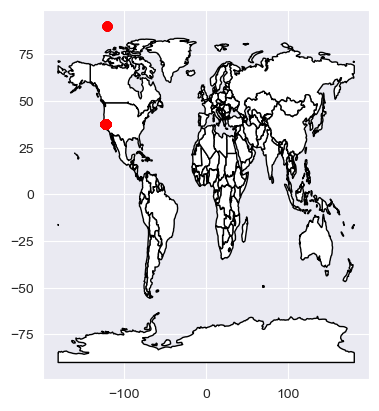

In [10]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(sf_crime_data)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [11]:
train_gdf = train_gdf.to_crs(epsg=3857)


In [12]:
print(sf_crime_data.loc[sf_crime_data.Y > 50].count())

Dates         67
Category      67
Descript      67
DayOfWeek     67
PdDistrict    67
Resolution    67
Address       67
X             67
Y             67
dtype: int64


In [13]:
sf_crime_data = sf_crime_data.drop(sf_crime_data[(sf_crime_data.Y > 50)].index)

In [14]:
sf_crime_data.shape

(875659, 9)

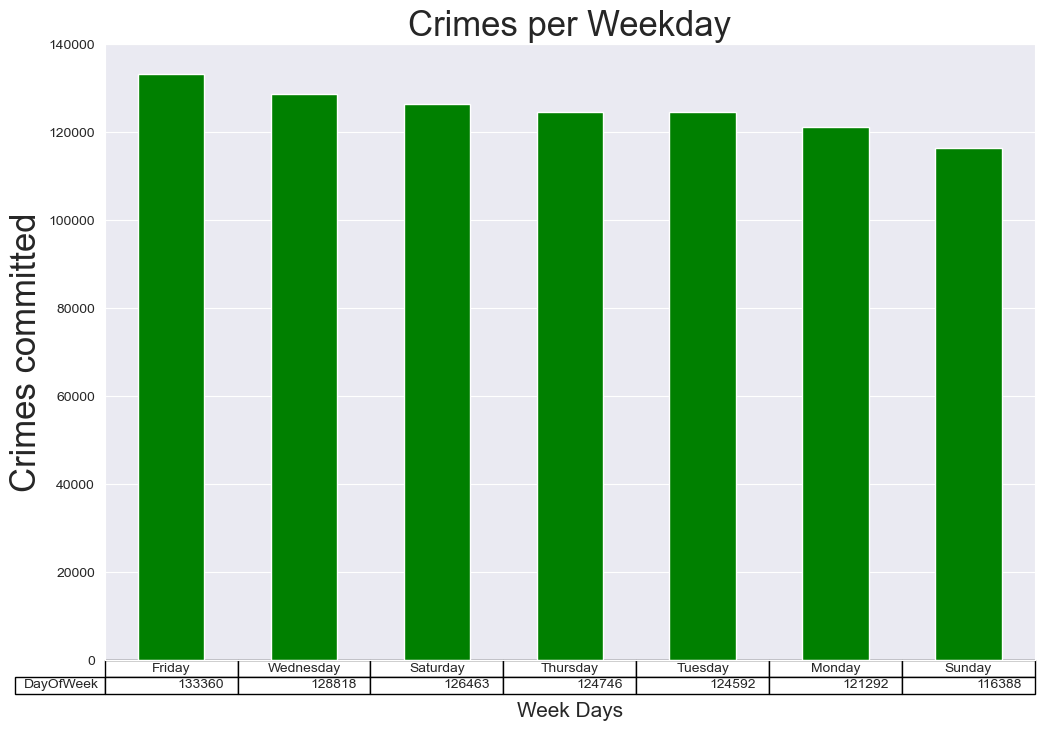

In [15]:
week = sf_crime_data['DayOfWeek'].value_counts()
week.plot(kind="bar",figsize=(12,8), table=True,  color='g')

plt.xticks([])
plt.xlabel('Week Days',fontsize=15,labelpad=30)
plt.ylabel('Crimes committed',fontsize=25)
plt.title('Crimes per Weekday',fontsize=25)
plt.show()

# week.describe()

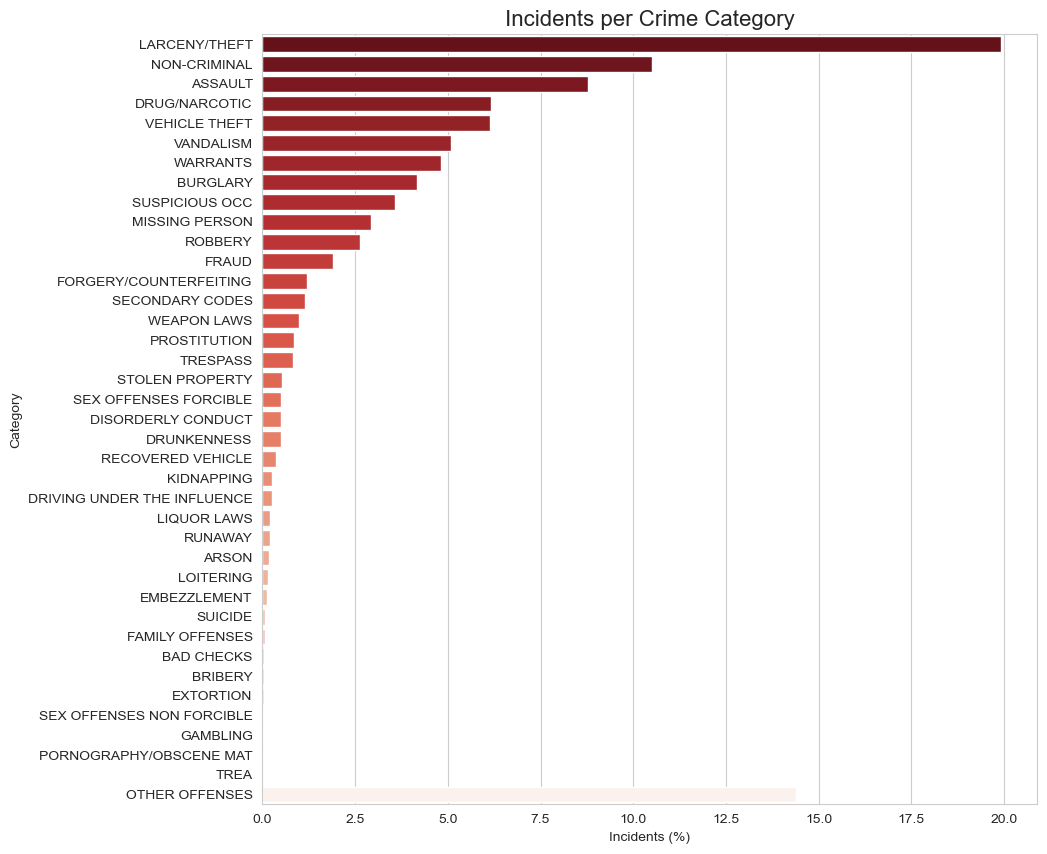

In [16]:
data = sf_crime_data.groupby('Category').count().iloc[:, 0].sort_values(ascending=False)
data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=(data.values / data.values.sum()) * 100,
        y=data.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()


/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_classification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_classification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


AttributeError: module 'contextily' has no attribute 'sources'

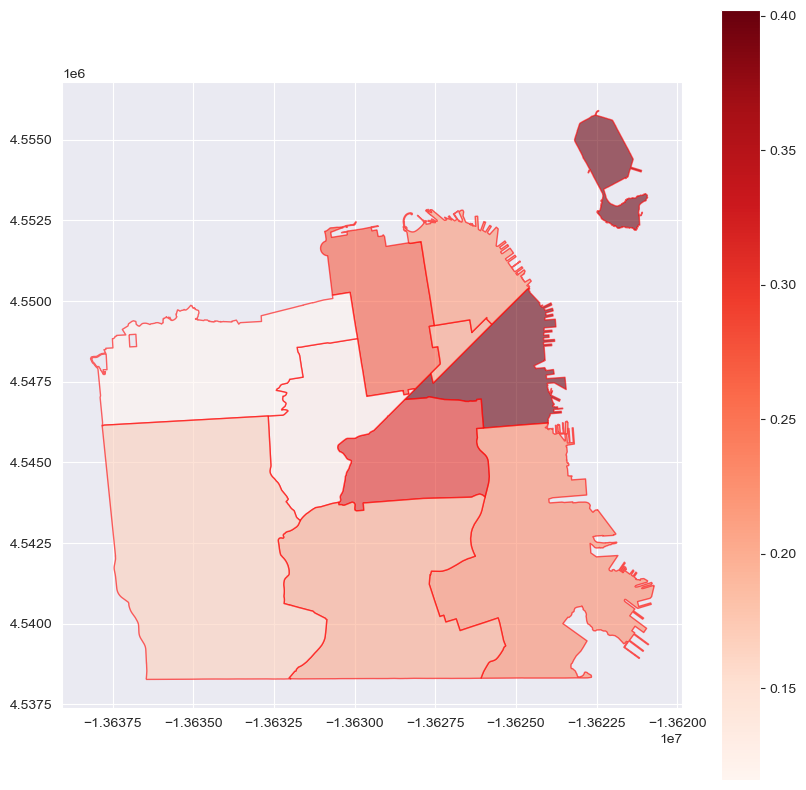

In [17]:
# Downloading the shapefile of the area
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train_gdf.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train_gdf.groupby('Dates').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()


<a name="fenigine"></a>
# Feature Selection/Extraction

Adding features like whether the crime was committed on holidays or how far was the address from the police stations maybe will help on classification task. So we're going to add **is_holiday** and **distance_from_pd**

In [19]:
!pip install holidays

In [20]:
import holidays

us_holidays = holidays.US()

sf_crime_data['Holiday'] = sf_crime_data['Dates'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

In [21]:
sf_crime_data['Holiday'].value_counts()

0    847693
1     27966
Name: Holiday, dtype: int64

In [22]:
# Filter the dataset for only holidays
holiday_data = sf_crime_data[sf_crime_data['Holiday'] == 1]

# Group by 'Category', count and sort
most_common_holiday_crimes = holiday_data.groupby('Category').size().sort_values(ascending=False)

# Print the results
most_common_holiday_crimes


Category
LARCENY/THEFT                  5310
OTHER OFFENSES                 4194
NON-CRIMINAL                   3079
ASSAULT                        2545
DRUG/NARCOTIC                  1748
VEHICLE THEFT                  1667
VANDALISM                      1438
WARRANTS                       1379
BURGLARY                       1117
SUSPICIOUS OCC                 1037
MISSING PERSON                  764
ROBBERY                         722
FRAUD                           474
SECONDARY CODES                 339
WEAPON LAWS                     301
FORGERY/COUNTERFEITING          292
TRESPASS                        259
SEX OFFENSES FORCIBLE           159
STOLEN PROPERTY                 157
DRUNKENNESS                     140
DISORDERLY CONDUCT              134
DRIVING UNDER THE INFLUENCE     107
KIDNAPPING                      103
RECOVERED VEHICLE                83
RUNAWAY                          63
PROSTITUTION                     58
LIQUOR LAWS                      57
LOITERING          

Next, we want to determine the distance from crime address to district's police station.

In [23]:
sf_crime_data['PdDistrict'].value_counts()

SOUTHERN      156520
MISSION       119722
NORTHERN      105093
BAYVIEW        89089
CENTRAL        85262
TENDERLOIN     81627
INGLESIDE      78718
TARAVAL        65396
PARK           49159
RICHMOND       45073
Name: PdDistrict, dtype: int64

In [24]:
!pip install geopy

In [25]:
from geopy.distance import geodesic


# Police station coordinates
police_stations = {
    'CENTRAL': (37.7986, -122.4101),
    'SOUTHERN': (37.77528, -122.40417),
    'BAYVIEW': (37.7298, -122.3977),
    'MISSION': (37.7628, -122.4220),
    'NORTHERN': (37.7802, -122.4324),
    'PARK': (37.76777, -122.45517),
    'RICHMOND': (37.7801, -122.4644),
    'INGLESIDE': (37.7247, -122.4463),
    'TARAVAL': (37.7437, -122.4815),
    'TENDERLOIN': (37.78368, -122.41292)
}

def calculate_distance(loc1, loc2):
    return geodesic(loc1, loc2).miles

sf_crime_data['Distance_from_pd'] = sf_crime_data.apply(lambda row: calculate_distance((row['Y'], row['X']), police_stations[row['PdDistrict']]), axis=1)


In [26]:
sf_crime_data

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Distance_from_pd,Holiday
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0.525518,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0.525518,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,1.461881,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,1.456104,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,0.936463,0
...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2.386263,0
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,0.503225,0
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,0.346481,0
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,0.832088,0


In [27]:
# We're adding hour as a feature too, because many crimes are more likely to be committed in the night than during the day
sf_crime_data['Hour']= sf_crime_data["Dates"].map(lambda x: x.hour)

In [28]:
def get_hour_zone(hour):
    if hour >= 2 and hour < 8: 
        return 0
    elif hour >= 8 and hour < 12: 
        return 1
    elif hour >= 12 and hour < 18: 
        return 2
    elif hour >= 18 and hour < 22: 
        return 3
    elif hour < 2 or hour >= 22: 
        return 4
    
sf_crime_data["Hour_Zone"] = sf_crime_data["Hour"].map(get_hour_zone)

In [29]:
sf_crime_data["Month"] = sf_crime_data["Dates"].map(lambda x: x.month)

In [30]:
sf_crime_data["Year"] = sf_crime_data["Dates"].map(lambda x: x.year)

## Season
The season feature may affect what type of crimes are commited.

1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall

In [31]:
sf_crime_data['Season']=(sf_crime_data['Month']%12 + 3)//3

## Business Hours Feature
There should be an effect of business hours on the type of crime committed
Let's create a binary feature where:
- 1 is typical business hours [8:00AM - 6:00PM]
- 0 is not business hours [6:01PM - 7:59 AM]

In [32]:
from datetime import datetime, time

def time_in_range(start, end, x):
    """Return true if x is in the inclusive range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

def map_business_hours(date):
    
    # Convert military time to AM & PM
    time_parsed = date.time()
    business_start = time(8, 0, 0)
    business_end = time(18, 0, 0)
    
    if time_in_range(business_start, business_end, time_parsed):
        return 1
    else:
        return 0
    
sf_crime_data['Business_Hour'] = sf_crime_data['Dates'].map(map_business_hours).astype('uint8')

In [33]:
sf_crime_data

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Distance_from_pd,Holiday,Hour,Hour_Zone,Month,Year,Season,Business_Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0.525518,0,23,4,5,2015,2,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0.525518,0,23,4,5,2015,2,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,1.461881,0,23,4,5,2015,2,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,1.456104,0,23,4,5,2015,2,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,0.936463,0,23,4,5,2015,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2.386263,0,0,4,1,2003,1,0
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,0.503225,0,0,4,1,2003,1,0
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,0.346481,0,0,4,1,2003,1,0
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,0.832088,0,0,4,1,2003,1,0


In [2]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
#from xgboost import XGBClassifier

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Metrics 
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

# Clustering
from sklearn.cluster import KMeans

# Mathematical Functions
import math

## Weekend
Weekends may have effect on what types of crimes are commmited
- Weekday = 0,
- Weekend =1

In [35]:
days = {'Monday':0 ,'Tuesday':0 ,'Wednesday':0 ,'Thursday':0 ,'Friday':0, 'Saturday':1 ,'Sunday':1}

sf_crime_data['Weekend'] = sf_crime_data['DayOfWeek'].replace(days).astype('uint8')


### Spatial Features
**Street Type**

The street type can have an effect on what type of crime is committed, so we want to extract the street type from the 'Address' feature.

We have avenues, streets, ways, boulevards, highways, courts, walks, plazas, and differet number of intersections of roads/streets (Addresses with /).

In [36]:
sf_crime_data['Address'].value_counts().index

Index(['800 Block of BRYANT ST', '800 Block of MARKET ST',
       '2000 Block of MISSION ST', '1000 Block of POTRERO AV',
       '900 Block of MARKET ST', '0 Block of TURK ST', '0 Block of 6TH ST',
       '300 Block of ELLIS ST', '400 Block of ELLIS ST',
       '16TH ST / MISSION ST',
       ...
       '300 Block of CHAINOFLAKES DR', 'DELMAR ST / PIEDMONT ST',
       'LAWTON ST / 46TH AV', 'GLADYS ST / SANTAMARINA ST',
       'BELLAVISTA WY / DORCAS WY', 'QUANE ST / 21ST ST',
       'IRVING ST / 39TH AV', 'ULLOA ST / 39TH AV', 'WILDER ST / CARRIE ST',
       'LEVANT ST / VULCAN STWY'],
      dtype='object', length=23191)

In [37]:
import re


def find_streets(address):
    street_types = ['AV', 'ST', 'CT', 'PZ', 'LN', 'DR', 'PL', 'HY',
                    'FY', 'WY', 'TR', 'RD', 'BL', 'WAY', 'CR', 'AL', 'I-80',
                    'RW', 'WK','EL CAMINO DEL MAR']
    street_pattern = '|'.join(street_types)
    streets = re.findall(street_pattern, address)
    if len(streets) == 0:
        # Debug
#         print(address)
        return 'OTHER'
    elif len(streets) == 1:
        return streets[0]
    else:
#         print(address)
        return 'INT'

sf_crime_data['StreetType'] = sf_crime_data['Address'].map(find_streets)

### Block Number Feature

Let's explore the block number from address
- Block number has ordinal data type (order matters), and has spatial significance
- It seems all the block numbers are in intervals of 100
- How to categorize
- Addresses that do not have a block number will be categorized as 0
- Addresses with block number will be divided by 100, and added by 1 for mapping (0 is saved for addresses with no block number)
- 85 unique block numbers (including 1 where there is no block number)

In [38]:
def find_block_number(address):
    block_num_pattern = '[0-9]+\s[Block]'
    block_num = re.search(block_num_pattern, address)
    if block_num:
#         print(address)
        num_pattern = '[0-9]+'
        block_no_pos = re.search(num_pattern, address)
        # Get integer of found regular expression
        block_no = int(block_no_pos.group())
        # Convert block number by dividing by 100 and adding 1 (0 = addresses with no block)
        block_map = (block_no // 100) + 1
#         print(block_map)
        return block_map
    else:
#         print(address)
        #
        return 0


sf_crime_data['BlockNo'] = sf_crime_data['Address'].map(find_block_number)

### X, Y Coordinates
Normalize and scale the X and Y coordinates
I use K-Means clustering to create a new feature for the longitude and latitude by grouping clusters of points based on Euclidean distances.
X = longitude, Y = latitude
I also extract more spatial features from the X, Y coordinates by transforming them from the cartesian space to the polar space (Reference)
three variants of rotated Cartesian coordinates (rotated by 30, 45, 60 degree each)
Polar coordinates (i.e. the 'r' and the angle 'theta')
The approach makes some intuitive sense i.e. that having such features should help in extracting some more spatial information (than relying on the current x-y alone)

In [39]:
# Normalize X and Y
print('There are %d unique longitude values, %d unique latitude values' % (sf_crime_data['X'].nunique(),
                                                                           sf_crime_data['Y'].nunique()))

xy_scaler = StandardScaler().fit(sf_crime_data[['X', 'Y']])
sf_crime_data[['X', 'Y']] = xy_scaler.transform(sf_crime_data[['X', 'Y']])

There are 34242 unique longitude values, 34242 unique latitude values


In [40]:
# X-Y plane rotation and space transformation to extract more spatial information
# 2-dimensional rotation based on below functions:
# rotated x = xcos - ysin
# rotated y = xsin + ycos
# Conver from cartesian space -> polar space

cos_30 = math.cos(math.radians(30))
sin_30 = math.sin(math.radians(30))
cos_45 = math.cos(math.radians(45))
sin_45 = math.sin(math.radians(45))
cos_60 = math.cos(math.radians(60))
sin_60 = math.sin(math.radians(60))


sf_crime_data["Rot30_X"] = sf_crime_data['X'] * cos_30 - sf_crime_data['Y'] * sin_30
sf_crime_data["Rot30_Y"] = sf_crime_data['X'] * sin_30 + sf_crime_data['Y'] * cos_30
sf_crime_data["Rot45_X"] = sf_crime_data['X'] * cos_45 - sf_crime_data['Y'] * sin_45
sf_crime_data["Rot45_Y"] = sf_crime_data['X'] * sin_45 + sf_crime_data['Y'] * cos_45
sf_crime_data["Rot60_X"] = sf_crime_data['X'] * cos_60 - sf_crime_data['Y'] * sin_60
sf_crime_data["Rot60_Y"] = sf_crime_data['X'] * sin_60 + sf_crime_data['Y'] * cos_60
sf_crime_data["Radius"] = np.sqrt(sf_crime_data['X'] ** 2 + sf_crime_data['Y'] ** 2)
sf_crime_data["Angle"] = np.arctan2(sf_crime_data['X'], sf_crime_data['Y'])

In [ ]:
coordinates = sf_crime_data.loc[:,['Y','X']]
num_clusters = 40
kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(coordinates)
id_labels=kmeans.labels_
sf_crime_data['Cluster'] = id_labels

/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_classification/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Feature Encoding

In [ ]:
# We don't need Dates, Descript, Resolution columns anymore
sf_crime_data.drop(['Dates', 'Descript', 'Resolution', 'Address'], axis=1, inplace=True)


### Pd Districts
Convert PdDistrict categorical feature to numeric

In [ ]:
pd_districts = {'SOUTHERN':0, 'MISSION':1, 'NORTHERN':2, 'CENTRAL':3, 'BAYVIEW':4, 'INGLESIDE':5,
                'TENDERLOIN':6, 'TARAVAL':7, 'PARK':8, 'RICHMOND':9}

sf_crime_data['PdDistrict'].replace(pd_districts, inplace=True)

In [ ]:
st_le = LabelEncoder()
st_le.fit(sf_crime_data['StreetType'].unique())
print(list(st_le.classes_))
sf_crime_data['StreetType']=st_le.transform(sf_crime_data['StreetType'])

### DayOfWeek
- We are going to use sklearn's LabelEncoder to encode the categorical data to numeric
- Day of week is considered a categorical and nominal variable

In [ ]:
week_days = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5,
                'Sunday':6}
sf_crime_data['DayOfWeek'].replace(week_days, inplace=True)

In [43]:
sf_crime_data['DayOfWeek'].value_counts()

4    133360
2    128818
5    126463
3    124746
1    124592
0    121292
6    116388
Name: DayOfWeek, dtype: int64

In [44]:
cat_le = LabelEncoder()
cat_le.fit(sf_crime_data['Category'].unique())
print(list(cat_le.classes_))
sf_crime_data['Category']=cat_le.transform(sf_crime_data['Category'])

['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']


In [45]:
dict(zip(cat_le.classes_, cat_le.transform(cat_le.classes_)))


{'ARSON': 0,
 'ASSAULT': 1,
 'BAD CHECKS': 2,
 'BRIBERY': 3,
 'BURGLARY': 4,
 'DISORDERLY CONDUCT': 5,
 'DRIVING UNDER THE INFLUENCE': 6,
 'DRUG/NARCOTIC': 7,
 'DRUNKENNESS': 8,
 'EMBEZZLEMENT': 9,
 'EXTORTION': 10,
 'FAMILY OFFENSES': 11,
 'FORGERY/COUNTERFEITING': 12,
 'FRAUD': 13,
 'GAMBLING': 14,
 'KIDNAPPING': 15,
 'LARCENY/THEFT': 16,
 'LIQUOR LAWS': 17,
 'LOITERING': 18,
 'MISSING PERSON': 19,
 'NON-CRIMINAL': 20,
 'OTHER OFFENSES': 21,
 'PORNOGRAPHY/OBSCENE MAT': 22,
 'PROSTITUTION': 23,
 'RECOVERED VEHICLE': 24,
 'ROBBERY': 25,
 'RUNAWAY': 26,
 'SECONDARY CODES': 27,
 'SEX OFFENSES FORCIBLE': 28,
 'SEX OFFENSES NON FORCIBLE': 29,
 'STOLEN PROPERTY': 30,
 'SUICIDE': 31,
 'SUSPICIOUS OCC': 32,
 'TREA': 33,
 'TRESPASS': 34,
 'VANDALISM': 35,
 'VEHICLE THEFT': 36,
 'WARRANTS': 37,
 'WEAPON LAWS': 38}

In [3]:
crime_data = pd.read_csv("final_train.csv", index_col=[0])
crime_data.head()

,Category,DayOfWeek,PdDistrict,X,Y,Holiday,Distance_from_pd,Hour,Hour_Zone,Month,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,37,2,2,-0.123472,0.312945,0,0.525518,23,4,5,...,0,-0.263403,0.209283,-0.308594,0.133978,-0.332755,0.049543,0.336423,-0.375798,13
1,21,2,2,-0.123472,0.312945,0,0.525518,23,4,5,...,0,-0.263403,0.209283,-0.308594,0.133978,-0.332755,0.049543,0.336423,-0.375798,13
2,21,2,2,-0.063006,1.381231,0,1.461881,23,4,5,...,0,-0.745180,1.164678,-1.021230,0.932126,-1.227684,0.636050,1.382667,-0.045584,0
3,16,2,2,-0.167127,1.400196,0,1.456104,23,4,5,...,16,-0.844834,1.129042,-1.108265,0.871911,-1.296169,0.555362,1.410135,-0.118798,0
4,16,2,8,-0.631594,0.186425,0,0.936463,23,4,5,...,2,-0.640189,-0.154348,-0.578427,-0.314782,-0.477246,-0.453764,0.658533,-1.283780,13


In [4]:
# Set training data (drop labels) and training labels
X_train = crime_data.drop("Category", axis=1).copy()
Y_train = crime_data["Category"].copy()


In [5]:
def one_hot_encode(train_data):
    '''One Hot Encode the categorical features'''
    encoded_train_data = train_data
    encoded_train_data = pd.concat([encoded_train_data,
                                    pd.get_dummies(pd.Series(encoded_train_data['StreetType']), prefix='StreetType')], axis=1)
    encoded_train_data = encoded_train_data.drop(['StreetType'], axis=1)

    return encoded_train_data

In [6]:
X_encoded_train = one_hot_encode(X_train)

In [7]:
# Use these for ML algorithms that can't handle categorical data (Logistic Regression, Linear Models)
mini_encoded_train_data, mini_encoded_dev_data, mini_train_labels, mini_dev_labels = train_test_split(X_encoded_train, 
                                                                                      Y_train,
                                                                                      stratify=Y_train,
                                                                                      test_size=0.2,
                                                                                      random_state=1)

In [8]:
# Use these for ML algorithms that can handle categorical data without OHE
mini_train_data, mini_dev_data, mini_train_labels, mini_dev_labels = train_test_split(X_train, 
                                                                                      Y_train,
                                                                                      stratify=Y_train,
                                                                                      test_size=0.2,
                                                                                      random_state=1)

In [9]:
mini_train_data.head()

,DayOfWeek,PdDistrict,X,Y,Holiday,Distance_from_pd,Hour,Hour_Zone,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
862083,3,0,0.581530,0.701642,0,0.637592,3,0,3,0,...,0,0.152799,0.898405,-0.084932,0.907340,-0.316875,0.854441,0.911306,0.692065,29
513071,2,5,0.364858,-2.253458,0,1.979539,23,4,2,5,...,2,1.442705,-1.769123,1.851429,-1.335442,2.133981,-0.810753,2.282804,2.981075,20
606759,2,2,0.044348,0.790649,0,0.717131,22,4,10,3,...,12,-0.356918,0.706896,-0.527714,0.590432,-0.662548,0.433731,0.791891,0.056032,6
168380,2,0,0.765998,0.346965,0,0.042999,16,2,2,10,...,9,0.489891,0.683479,0.296301,0.786984,0.082518,0.836856,0.840914,1.145485,30
550516,1,7,-1.755560,-2.220983,0,2.234863,22,4,8,4,...,2,-0.409868,-2.801207,0.329104,-2.811840,1.045648,-2.630851,2.831034,-2.472707,32


In [ ]:
# K Neighbors
knn = KNeighborsClassifier(n_neighbors=37)
knn.fit(mini_train_data, mini_train_labels)
pred_probs = knn.predict_proba(mini_dev_data)
knn_loss = log_loss(mini_dev_labels, pred_probs)


print('KNN Validation Log Loss: ', knn_loss)

In [13]:
# Naive Bayes
gaussian = GaussianNB()
gaussian.fit(mini_train_data, mini_train_labels)
pred_probs = gaussian.predict_proba(mini_dev_data)
nb_loss = log_loss(mini_dev_labels, pred_probs)


print('Gaussian Naive Bayes Validation Log Loss: ', nb_loss)

Gaussian Naive Bayes Validation Log Loss:  4.088741407460626


In [10]:
import pickle

# pickle.dump(gaussian, open('gaussianNB_model.pkl', 'wb'))


In [16]:
# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(penalty='elasticnet', loss='log', 
                                  tol=0.0001, max_iter=1000, n_jobs=1000, random_state=1)
sgd.fit(mini_encoded_train_data, mini_train_labels)
pred_probs = sgd.predict_proba(mini_encoded_dev_data)
# sgd.fit(one_hot_encode(mini_train_data), mini_train_labels)
# sgd = gaussian.predict_proba(one_hot_encode(mini_dev_data))
sgd_loss = log_loss(mini_dev_labels, pred_probs)

print('Linear Model SGD Validation Log Loss: ', sgd_loss)

/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_classification/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Linear Model SGD Validation Log Loss:  2.5932852782501903


In [18]:
pickle.dump(sgd, open('sgd_model.pkl', 'wb'))


In [1]:
# Logistic Regression
logreg = LogisticRegression(penalty='l1', C=1.5, solver='saga', multi_class='multinomial',
                            tol=0.0001, max_iter=1000, verbose=3, n_jobs=1000, random_state=1)

logreg.fit(mini_encoded_train_data, mini_train_labels)
pred_probs = logreg.predict_proba(mini_encoded_dev_data)

logreg_loss = log_loss(mini_dev_labels, pred_probs)


print('Logistic Regression Validation Log Loss: ', logreg_loss)

NameError: name 'LogisticRegression' is not defined

In [4]:
from xgboost import XGBClassifier

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# XGBoost Ensemble
# xgb = XGBClassifier(n_estimators=100, verbose=3, n_jobs=2, random_state=1)
xgb = XGBClassifier(n_estimators=500, objective="multi:softprob",
                    verbose=3, n_jobs=2000, random_state=1)

xgb.fit(mini_encoded_train_data, mini_train_labels)
pred_probs = xgb.predict_proba(mini_encoded_dev_data)

xgb_loss = log_loss(mini_dev_labels, pred_probs)

print('XGBoost Validation Log Loss: ', xgb_loss)

In [2]:
pickle.dump(xgb, open('xgb_model.pkl', 'wb'))


NameError: name 'pickle' is not defined